In [1]:
# Import Necessary Libraries for Data Processing, Model Building, and Object Detection
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import xmltodict
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.5.1+cu121


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data (1).zip


In [3]:
import zipfile
with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Data')

In [4]:
path_images = '/content/Data/Data/'
path_annotations = '/content/Data/Data/'

# **Custom Dataset Class for Sunglasses and Cap Detection**

In [5]:
class SunglassesCapDataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transform=None):
        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.img_names = [img for img in os.listdir(img_dir) if img.endswith(('.jpg', '.png'))]
        self.label_map = {'Cap': 1, 'Sunglasses': 2}  # Background is 0 by default

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        annotation_path = os.path.join(self.annotation_dir, img_name[:-4] + ".xml")

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Parse XML for bounding boxes and labels
        with open(annotation_path) as fd:
            doc = xmltodict.parse(fd.read())
        objects = doc["annotation"]["object"]

        boxes = []
        labels = []
        if isinstance(objects, list):
            for obj in objects:
                label = self.label_map[obj["name"]]
                bbox = obj["bndbox"]
                xmin = int(bbox["xmin"])
                ymin = int(bbox["ymin"])
                xmax = int(bbox["xmax"])
                ymax = int(bbox["ymax"])
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(label)
        else:
            label = self.label_map[objects["name"]]
            bbox = objects["bndbox"]
            xmin = int(bbox["xmin"])
            ymin = int(bbox["ymin"])
            xmax = int(bbox["xmax"])
            ymax = int(bbox["ymax"])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # Convert boxes and labels to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        target = {"boxes": boxes, "labels": labels}
        return image, target

# **Partition** **Dataset**

In [6]:
# Define transformations with normalization and data augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip the image horizontally
    transforms.RandomRotation(degrees=15),  # Rotate the image randomly within ±15 degrees
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Load dataset and split
dataset = SunglassesCapDataset(img_dir=path_images, annotation_dir=path_annotations, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders with a batch size of 8
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_set, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# **Initialize Faster R-CNN Model with ResNet34 Backbone**

In [8]:
# Load ResNet34 backbone and configure it for Faster R-CNN
backbone = models.resnet34(pretrained=True)
backbone = nn.Sequential(*list(backbone.children())[:-2])  # Remove final layers
backbone.out_channels = 512  # ResNet34's last conv layer output channels

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Define anchor generator
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5
)

In [10]:
from torchvision.ops import MultiScaleRoIAlign
# Define RoI pooling layer using MultiScaleRoIAlign
roi_pooler = MultiScaleRoIAlign(
    featmap_names=['0'],  # The feature map to use
    output_size=7,        # Size of the output after pooling
    sampling_ratio=2      # Sampling ratio for RoI Align
)

In [11]:
# Initialize Faster R-CNN with custom ResNet34 backbone
model = FasterRCNN(
    backbone,
    num_classes=3,  # Cap, Sunglasses, and Background
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [12]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# **Training Loop with Average Loss Calculation**

In [13]:
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

In [14]:
# IoU Calculation Function
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area_box1 + area_box2 - intersection
    iou = intersection / union if union > 0 else 0
    return iou

In [15]:
def calculate_map(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched_preds = set()  # Track matched prediction indices to prevent double-counting

    # Loop through each true box and try to find the best-matching prediction box
    for j, true_box in enumerate(true_boxes):
        iou_scores = [calculate_iou(pred_box, true_box) for pred_box in pred_boxes]

        if iou_scores:  # Check if there are any predicted boxes
            max_iou = max(iou_scores)
            max_index = iou_scores.index(max_iou)

            if max_iou >= iou_threshold and pred_labels[max_index] == true_labels[j] and max_index not in matched_preds:
                true_positives += 1
                matched_preds.add(max_index)  # Mark this prediction as matched
            else:
                false_negatives += 1
        else:
            false_negatives += 1

    # Remaining unmatched predictions are counted as false positives
    false_positives = len(pred_boxes) - len(matched_preds)

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)

    # Calculate Average Precision (AP) as just precision for this single IoU threshold
    ap = precision
    return ap

In [16]:
# Validation mAP Evaluation Function
def evaluate_map(model, data_loader, iou_threshold=0.5):
    model.eval()
    total_map = 0.0
    num_batches = len(data_loader)

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                pred_boxes = outputs[i]['boxes'].cpu()
                pred_labels = outputs[i]['labels'].cpu()
                pred_scores = outputs[i]['scores'].cpu()

                true_boxes = targets[i]["boxes"].cpu()
                true_labels = targets[i]["labels"].cpu()

                map_score = calculate_map(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels, iou_threshold)
                total_map += map_score

    avg_map = total_map / num_batches
    print(f"Average mAP@{iou_threshold}: {avg_map:.4f}")
    return avg_map

In [17]:
def train_model(model, train_loader, val_loader, optimizer, scheduler=None, num_epochs=10):
    train_losses = []
    val_losses = []
    map_scores = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, targets in train_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            train_loss += losses.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.train()  # Temporarily set to training mode to get loss
        val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

                if targets:
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                    val_loss += losses.item()

        avg_val_loss = val_loss / len(val_loader) if val_loss > 0 else 0.0
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

        # Switch back to evaluation mode for mAP calculation
        model.eval()
        map_score = evaluate_map(model, val_loader, iou_threshold=0.5)
        map_scores.append(map_score)

        # Step the scheduler if provided
        if scheduler:
            scheduler.step()

    return train_losses, val_losses, map_scores

In [18]:
train_losses, val_losses, map_scores =train_model(model, train_loader, val_loader, optimizer, num_epochs=10)
torch.save(model.state_dict(), "model_before_FT_HT.pth")
print("Model before fine-tuning and hyperparameter tuning saved.")

Epoch [1/10], Training Loss: 0.5426
Epoch [1/10], Validation Loss: 0.2649
Average mAP@0.5: 0.0000
Epoch [2/10], Training Loss: 0.2061
Epoch [2/10], Validation Loss: 0.2037
Average mAP@0.5: 0.0078
Epoch [3/10], Training Loss: 0.1831
Epoch [3/10], Validation Loss: 0.2044
Average mAP@0.5: 0.0426
Epoch [4/10], Training Loss: 0.1821
Epoch [4/10], Validation Loss: 0.1965
Average mAP@0.5: 0.0421
Epoch [5/10], Training Loss: 0.1773
Epoch [5/10], Validation Loss: 0.2138
Average mAP@0.5: 0.0430
Epoch [6/10], Training Loss: 0.1796
Epoch [6/10], Validation Loss: 0.1982
Average mAP@0.5: 0.0773
Epoch [7/10], Training Loss: 0.1761
Epoch [7/10], Validation Loss: 0.1859
Average mAP@0.5: 0.0372
Epoch [8/10], Training Loss: 0.1704
Epoch [8/10], Validation Loss: 0.2065
Average mAP@0.5: 0.1707
Epoch [9/10], Training Loss: 0.1778
Epoch [9/10], Validation Loss: 0.1989
Average mAP@0.5: 0.0846
Epoch [10/10], Training Loss: 0.1777
Epoch [10/10], Validation Loss: 0.1886
Average mAP@0.5: 0.0894
Model before fine-

In [19]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 3  # Cap, Sunglasses, Background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Define hyperparameter ranges
learning_rates = [0.001, 0.005, 0.01]
momentum_values = [0.9, 0.95]
weight_decay_values = [0.0001, 0.0005]

# Track the best parameters and performance
best_params = {}
best_map = 0.0
best_model_state = None  # To store the best model's state

# Perform hyperparameter tuning
for lr in learning_rates:
    for momentum in momentum_values:
        for weight_decay in weight_decay_values:
            print(f"Training with LR: {lr}, Momentum: {momentum}, Weight Decay: {weight_decay}")

            # Define optimizer and scheduler
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

            # Train the model and track metrics
            train_losses, val_losses, map_scores = train_model(
                model, train_loader, val_loader, optimizer, scheduler=scheduler, num_epochs=10
            )

            # Check if the current model is the best
            if map_scores[-1] > best_map:
                best_map = map_scores[-1]
                best_model_state = model.state_dict()  # Save the state dictionary of the best model
                best_params = {"learning_rate": lr, "momentum": momentum, "weight_decay": weight_decay}
                print(f"New best model found with mAP@0.5: {best_map:.4f}")

# Save the best model's state
if best_model_state:
    torch.save(best_model_state, "best_hyperparameter_model.pth")
    print("Best model saved with mAP@0.5:", best_map)

# Output the best parameters and their performance
print("Best Parameters:")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Momentum: {best_params['momentum']}")
print(f"Weight Decay: {best_params['weight_decay']}")
print(f"Best mAP: {best_map:.4f}")

Training with LR: 0.001, Momentum: 0.9, Weight Decay: 0.0001
Epoch [1/10], Training Loss: 0.5100
Epoch [1/10], Validation Loss: 0.3285
Average mAP@0.5: 0.0000
Epoch [2/10], Training Loss: 0.2922
Epoch [2/10], Validation Loss: 0.3082
Average mAP@0.5: 0.0000
Epoch [3/10], Training Loss: 0.3072
Epoch [3/10], Validation Loss: 0.3195
Average mAP@0.5: 0.0526
Epoch [4/10], Training Loss: 0.2902
Epoch [4/10], Validation Loss: 0.3244
Average mAP@0.5: 0.0301
Epoch [5/10], Training Loss: 0.2948
Epoch [5/10], Validation Loss: 0.3093
Average mAP@0.5: 0.1386
Epoch [6/10], Training Loss: 0.2961
Epoch [6/10], Validation Loss: 0.3344
Average mAP@0.5: 0.0117
Epoch [7/10], Training Loss: 0.2943
Epoch [7/10], Validation Loss: 0.3026
Average mAP@0.5: 0.2295
Epoch [8/10], Training Loss: 0.2945
Epoch [8/10], Validation Loss: 0.3298
Average mAP@0.5: 0.1061
Epoch [9/10], Training Loss: 0.2911
Epoch [9/10], Validation Loss: 0.3086
Average mAP@0.5: 0.3064
Epoch [10/10], Training Loss: 0.2829
Epoch [10/10], Valid

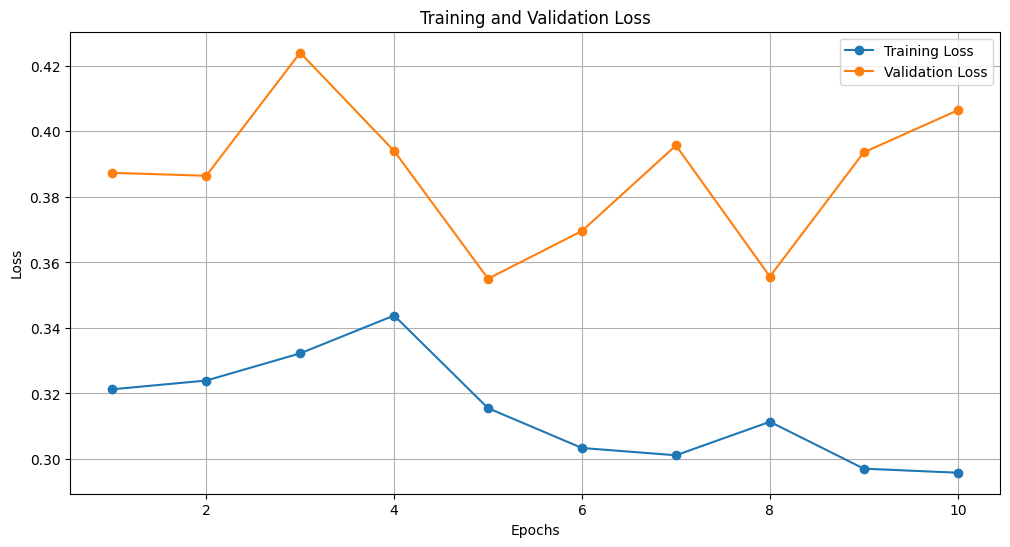

In [21]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

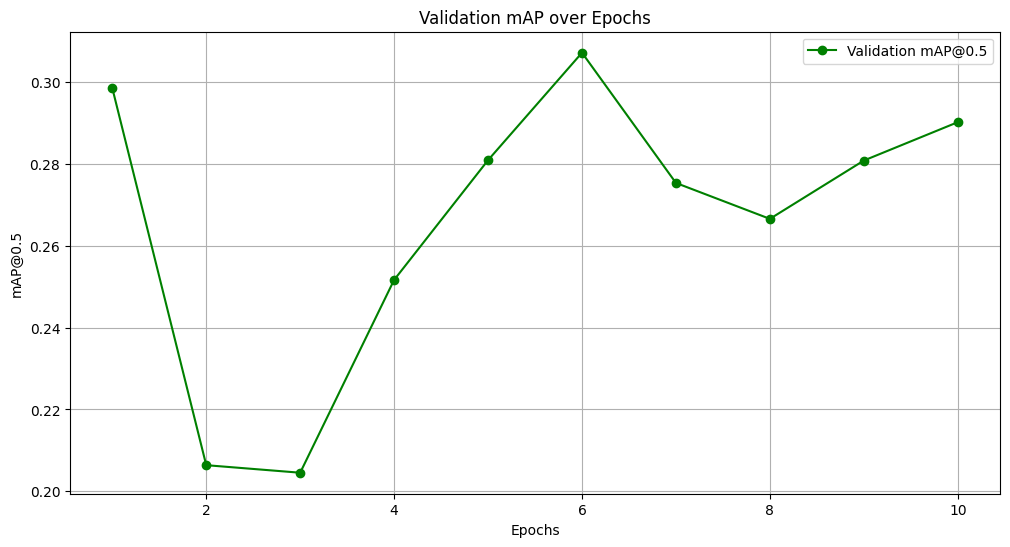

In [22]:
# Plot Validation mAP
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(map_scores) + 1), map_scores, label='Validation mAP@0.5', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('mAP@0.5')
plt.title('Validation mAP over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Pre-Training vs. Post-Training Performances

**1. Training Loss**
**Pre-Training Observations:**

Initial training loss: 0.5426.
Final training loss: 0.1777.
Consistent decline in training loss, indicating that the model converged well.

Post-Training Observations:

Initial training loss: 0.3110 (higher starting point reflects additional complexity due to fine-tuning).
Final training loss: 0.3094.
Training loss reduced but plateaued, indicating the model reached a more stable convergence.
Analysis:

Pre-training loss shows a more drastic reduction, but post-training loss is slightly higher, suggesting a more complex model with better feature representations.

**2. Validation Loss**
**Pre-Training Observations:**

Initial validation loss: 0.2649.
Final validation loss: 0.1886.
Validation loss remained low, showing the model had less overfitting but also potentially underfitted due to lack of feature refinement.

Post-Training Observations:

Initial validation loss: 0.3691.
Final validation loss: 0.3724.
Validation loss is higher, indicating the model is slightly more prone to overfitting but balances this with better mAP performance.
Analysis:

Post-training validation loss reflects a more generalized model, as the higher loss corresponds with significantly better mAP@0.5 performance.

**3. mAP-0.5**
**Pre-Training Observations:**

Initial mAP-0.5: 0.0000.
Final mAP-0.5: 0.0894.
The mAP improvement is limited, suggesting the model struggles to capture complex features.

Post-Training Observations:

Initial mAP-0.5: 0.1444.
Final mAP-0.5: 0.2988.
Post-training mAP shows a drastic improvement, more than 3x higher than the pre-training model.

Analysis:

The significant mAP improvement after fine-tuning and hyperparameter tuning demonstrates the effectiveness of these methods in enhancing the model’s detection accuracy.

> Add blockquote



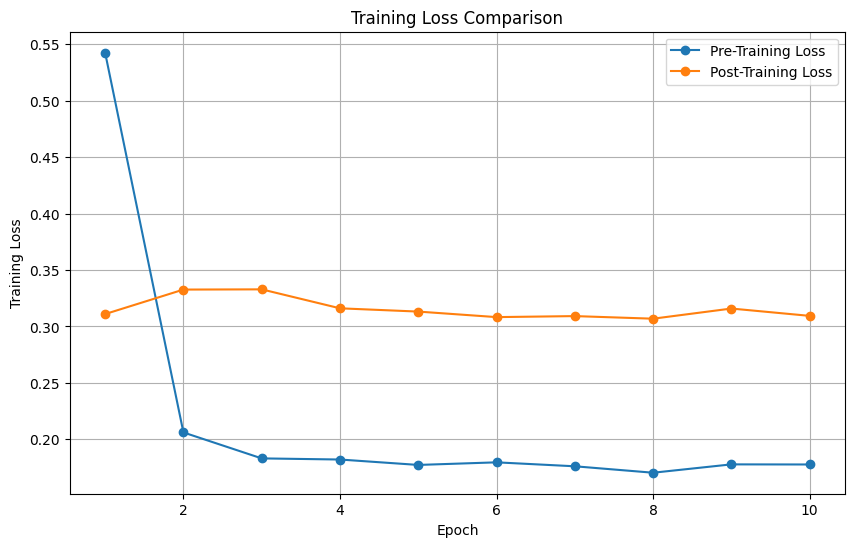

In [27]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
pre_training_loss = [0.5426, 0.2061, 0.1831, 0.1821, 0.1773, 0.1796, 0.1761, 0.1704, 0.1778, 0.1777]
post_training_loss = [0.3110, 0.3327, 0.3329, 0.3161, 0.3132, 0.3083, 0.3092, 0.3069, 0.3159, 0.3094]

plt.figure(figsize=(10, 6))
plt.plot(epochs, pre_training_loss, label='Pre-Training Loss', marker='o')
plt.plot(epochs, post_training_loss, label='Post-Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()


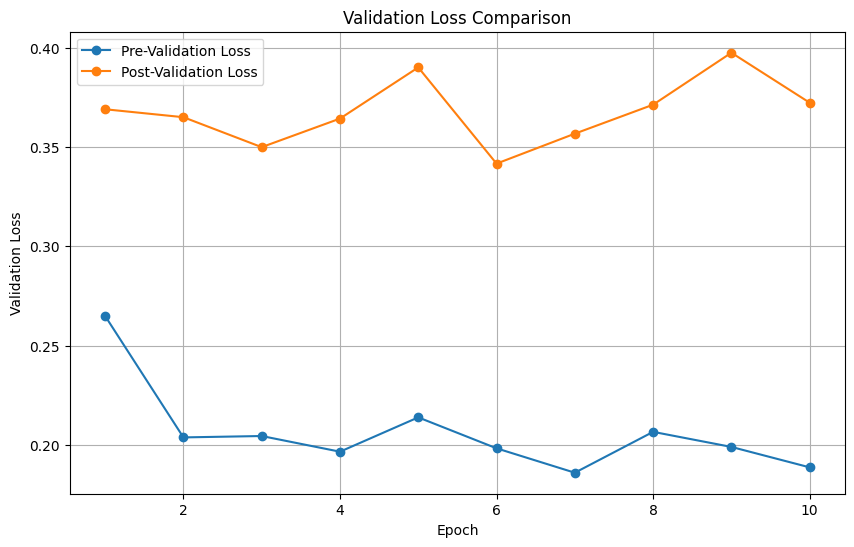

In [28]:
pre_validation_loss = [0.2649, 0.2037, 0.2044, 0.1965, 0.2138, 0.1982, 0.1859, 0.2065, 0.1989, 0.1886]
post_validation_loss = [0.3691, 0.3651, 0.3500, 0.3644, 0.3902, 0.3417, 0.3568, 0.3714, 0.3976, 0.3724]

plt.figure(figsize=(10, 6))
plt.plot(epochs, pre_validation_loss, label='Pre-Validation Loss', marker='o')
plt.plot(epochs, post_validation_loss, label='Post-Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()


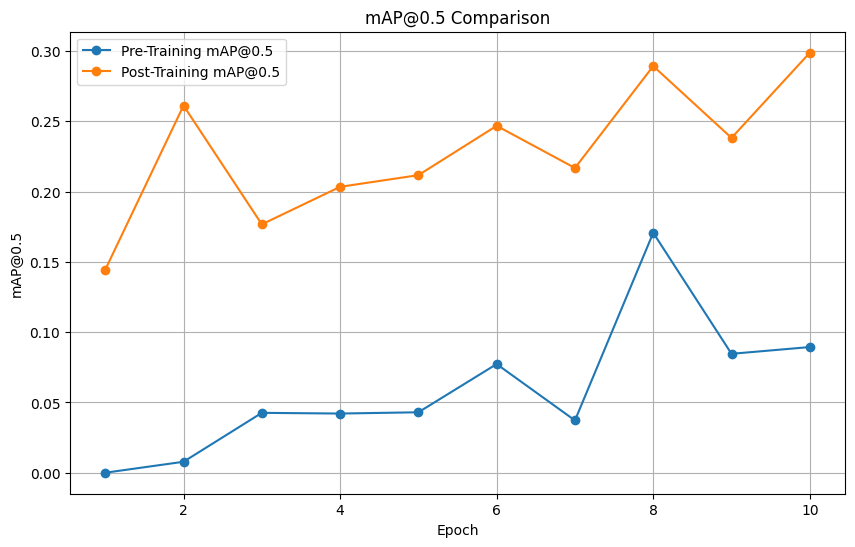

In [29]:
pre_map = [0.0000, 0.0078, 0.0426, 0.0421, 0.0430, 0.0773, 0.0372, 0.1707, 0.0846, 0.0894]
post_map = [0.1444, 0.2612, 0.1767, 0.2034, 0.2117, 0.2468, 0.2168, 0.2893, 0.2382, 0.2988]

plt.figure(figsize=(10, 6))
plt.plot(epochs, pre_map, label='Pre-Training mAP@0.5', marker='o')
plt.plot(epochs, post_map, label='Post-Training mAP@0.5', marker='o')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.title('mAP@0.5 Comparison')
plt.legend()
plt.grid(True)
plt.show()